# About

See what BERT is all about. This version is meant to run on a laptop

replication of the following blog post:

### News Topic Similarity Measure using Pretrained BERT Model

https://medium.com/the-artificial-impostor/news-topic-similarity-measure-using-pretrained-bert-model-1dbfe6a66f1d

https://github.com/ceshine/pytorch-pretrained-BERT/blob/master/notebooks/Next%20Sentence%20Prediction.ipynb

https://anaconda.org/conda-forge/pytorch-pretrained-bert

various implementations of BERT

https://pypi.org/project/pytorch-pretrained-bert/

get the pytorch

https://github.com/huggingface/transformers


### Understanding searches better than ever before

google's white paper

https://www.blog.google/products/search/search-language-understanding-bert


In [3]:
SEED = 42
PYTORCH_PRETRAINED_BERT_CACHE = "../models/bert_en_uncased_L-12_H-768_A-12/1"

In [21]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")

In [27]:
import json
import gc

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
# probably not necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

# Data Prep

In [8]:
# we're not using NYTimes article feed
# instead of the News Title vs News Body, we have Question Title vs Question Body

# p_questions = "/mnt/disks/disk-1-w210-data/data/interim/stackexchange/stackoverflow/PostQuestionsFiltered_V3_parsed.tsv"
# questions = pd.read_csv(p_questions, delimiter = "\t", encoding = "utf-8")

# p_answers = "/mnt/disks/disk-1-w210-data/data/interim/stackexchange/stackoverflow/PostAnswersFiltered_V3_parsed.tsv"
# answers = pd.read_csv(p_answers, delimiter = "\t", encoding = "utf-8")

FileNotFoundError: [Errno 2] File b'/mnt/disks/disk-1-w210-data/data/interim/stackexchange/stackoverflow/PostQuestionsFiltered_V3_parsed.tsv' does not exist: b'/mnt/disks/disk-1-w210-data/data/interim/stackexchange/stackoverflow/PostQuestionsFiltered_V3_parsed.tsv'

# sample

In [4]:
# t1 = questions[questions["accepted_answer_id"] > 0]
# questions_sample = t1.sample(600, random_state = 20191102)

In [5]:
# questions_sample.head(3)

,Unnamed: 0,Unnamed: 0.1,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,...,seaborn,geospatial,stata,plyr,pie-chart,graphviz,spss,diagram,qlikview,altair
557822,557822,557822,17108288,Why is my CSS :hover @keyframes animation not ...,<p>I am a newbie. Why is this code not working...,17108610.0,1,18,NaN,2013-06-14 12:16:20.233000+00:00,...,0,0,0,0,0,0,0,0,0,0
209952,209952,209952,13656097,Mixing line and scatterplot in ggplot,<p>I've looked around a fair bit but I am stum...,13656277.0,2,0,NaN,2012-12-01 03:35:01.673000+00:00,...,0,0,0,0,0,0,0,0,0,0
275911,275911,275911,395599,Java graphic library for multicoloured text,<p>I would like to know the recommended librar...,395679.0,4,0,NaN,2008-12-27 23:44:33.840000+00:00,...,0,0,0,0,0,0,0,0,0,0


# corpus

In [6]:
# constructs corpus
# with question id, title, accepted answer id, answer body
def construct_corpus(questions, answers = answers):
    t1 = questions[["id", "title", "tags", "accepted_answer_id"]].rename(columns = {"id" : "q_id", "title" : "q_title"})
    t2 = answers[["id", "body"]].rename(columns = {"id" : "a_id", "body" : "a_body"})
    t3 = t1.merge(t2, left_on = "accepted_answer_id", right_on = "a_id", how = "inner").drop(columns = "a_id")
    return(t3)

In [7]:
# corpus = construct_corpus(questions_sample)
# corpus.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body
0,17108288,Why is my CSS :hover @keyframes animation not ...,htmlcss3cross-browsercss-animations,17108610.0,<p>here it is:</p>\r\n\r\n<p>u have to add ven...
1,13656097,Mixing line and scatterplot in ggplot,rggplot2,13656277.0,"<p>As @MattBagg has pointed out, this issue is..."
2,395599,Java graphic library for multicoloured text,javagraphics,395679.0,<p>I'm assuming you're rendering text to an ar...


In [13]:
# writes corpus to interim location
# corpus.to_csv("../data/interim/yyq_sample_corpus.tsv", delim = "\t")
# corpus.to_excel("../data/interim/yyq_sample_corpus.xlsx")

In [9]:
p_corpus_sample = "../data/interim/yyq_sample_corpus.xlsx"
corpus = pd.read_excel(p_corpus_sample, index_col = None).drop(["Unnamed: 0"], axis = 1)

In [10]:
corpus.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body
0,17108288,Why is my CSS :hover @keyframes animation not ...,htmlcss3cross-browsercss-animations,17108610,<p>here it is:</p>\r\n\r\n<p>u have to add ven...
1,13656097,Mixing line and scatterplot in ggplot,rggplot2,13656277,"<p>As @MattBagg has pointed out, this issue is..."
2,395599,Java graphic library for multicoloured text,javagraphics,395679,<p>I'm assuming you're rendering text to an ar...


# helper functions from the blog

In [11]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [12]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [13]:
def convert_sentence_pair(titles, descs, max_seq_length, tokenizer):
    features = []
    for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
        tokens_a = tokenizer.tokenize(title)

        tokens_b = None
        tokens_b = tokenizer.tokenize(desc)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1
        ))
    return features

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231508/231508 [00:00<00:00, 4457611.70B/s]


In [17]:
corpus.q_title.tolist()

['Why is my CSS :hover @keyframes animation not working?',
 'Mixing line and scatterplot in ggplot',
 'Java graphic library for multicoloured text',
 'what would be a good way to have a day background and night backgroud switch over with time am pm?',
 'ForeignObject text not appearing',
 'igraph graph.data.frame silently converts factors to character vectors',
 'How can I write a multi-line if block on Bitbucket Pipeline?',
 'C# List elements lifetime Unity3d',
 'Vertex label in JUNG graph visualization',
 'Get a color component from an rgb string in Javascript?',
 'iOS app crashes on device not simulator: Im using an animation with 280+ images',
 'Stage untracked files for commit without staging tracked file changes',
 'Dictionary uses tostring instead of object?',
 'Writing text into and retrieving text from the text file using command line auguments',
 'Overlaying ggplot data layers',
 'How to create an Orbit Chart in R? (Plotly/ggplot2)',
 'Highcharts metric prefix',
 "Using Rapha

In [19]:
corpus.a_body.tolist()

['<p>here it is:</p>\r\n\r\n<p>u have to add vendor prefixes</p>\r\n\r\n<pre><code>.twitter-bird {\r\n    height: 38px;\r\n    width: 37.5px;\r\n    background-image: url("http://dl.dropboxusercontent.com/u/105046436/tw.png");\r\n}\r\n\r\n.twitter-bird:hover { \r\n    -webkit-animation: fly .4s steps(3) infinite;\r\n       -moz-animation: fly .4s steps(3) infinite;\r\n        -ms-animation: fly .4s steps(3) infinite;\r\n         -o-animation: fly .4s steps(3) infinite;\r\n            animation: fly .4s steps(3) infinite;\r\n}\r\n\r\n@-webkit-keyframes fly {\r\n   from { background-position:    0px; }\r\n     to { background-position: -112.5px; }\r\n}\r\n\r\n@-moz-keyframes fly {\r\n   from { background-position:    0px; }\r\n     to { background-position: -112.5px; }\r\n}\r\n\r\n@-ms-keyframes fly {\r\n   from { background-position:    0px; }\r\n     to { background-position: -112.5px; }\r\n}\r\n\r\n@-o-keyframes fly {\r\n   from { background-position:    0px; }\r\n     to { background

In [22]:
correct_pairs = convert_sentence_pair(corpus.q_title.tolist(), corpus.a_body.tolist(), max_seq_length=200, tokenizer=tokenizer)

11/06/2019 18:16:12 - INFO - bert -   *** Example ***
11/06/2019 18:16:12 - INFO - bert -   tokens: [CLS] why is my cs ##s : hove ##r @ key ##frame ##s animation not working ? [SEP] < p > here it is : < / p > < p > u have to add vendor prefix ##es < / p > < pre > < code > . twitter - bird { height : 38 ##p ##x ; width : 37 . 5 ##p ##x ; background - image : ur ##l ( " http : / / dl . drop ##box ##user ##con ##ten ##t . com / u / 105 ##0 ##46 ##43 ##6 / t ##w . p ##ng " ) ; } . twitter - bird : hove ##r { - web ##kit - animation : fly . 4 ##s steps ( 3 ) infinite ; - mo ##z - animation : fly . 4 ##s steps ( 3 ) infinite ; - ms - animation : fly . 4 ##s steps ( 3 ) infinite ; - o - animation : fly . 4 ##s steps ( 3 ) infinite ; animation : fly . 4 ##s steps ( 3 ) infinite ; } @ - web ##kit - key ##frame ##s [SEP]
11/06/2019 18:16:12 - INFO - bert -   input_ids: 101 2339 2003 2026 20116 2015 1024 25215 2099 1030 3145 15643 2015 7284 2025 2551 1029 102 1026 1052 1028 2182 2009 2003 1024 10

11/06/2019 18:16:12 - INFO - bert -   *** Example ***
11/06/2019 18:16:12 - INFO - bert -   tokens: [CLS] what would be a good way to have a day background and night back ##gr ##oud switch over with time am pm ? [SEP] < pre > < code > using unity ##eng ##ine ; using system . collections ; public class random ##ise ##back ##ground : mono ##be ##ha ##vio ##ur { public sp ##rite ##ren ##der ##er backgrounds ##pr ##iter ##end ##ere ##r ; public sp ##rite [ ] backgrounds ##pr ##ites ; / / use this for initial ##ization void start ( ) { int days ##tar ##t = 7 ; int days ##top = 22 ; if ( date ##time . now . hour & gt ; days ##tar ##t & amp ; & amp ; date ##time . now . hour & lt ; days ##top ) { / / display background by day } else { / / display background by night } } < / code > < / pre > < p > is this what you ' re looking for ? you could adjust it to use the pm / am method . . < / p > [SEP]
11/06/2019 18:16:12 - INFO - bert -   input_ids: 101 2054 2052 2022 1037 2204 2126 2000 2031 1037 2

In [23]:
len(correct_pairs)

600

# Model

In [24]:
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

11/06/2019 18:17:12 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz not found in cache, downloading to C:\Users\yangyq\AppData\Local\Temp\tmp_cxyvokf
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407873900/407873900 [00:59<00:00, 6824117.52B/s]
11/06/2019 18:18:12 - INFO - pytorch_pretrained_bert.file_utils -   copying C:\Users\yangyq\AppData\Local\Temp\tmp_cxyvokf to cache at ../models/bert_en_uncased_L-12_H-768_A-12/1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
11/06/2019 18:18:22 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for ../models/bert_en_uncased_L-12_H-768_A-12/1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55

# Eval Correct Pairs

In [28]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

11/06/2019 18:23:27 - INFO - bert -   ***** Running evaluation *****
11/06/2019 18:23:27 - INFO - bert -     Num examples = 600
11/06/2019 18:23:27 - INFO - bert -     Batch size = 128


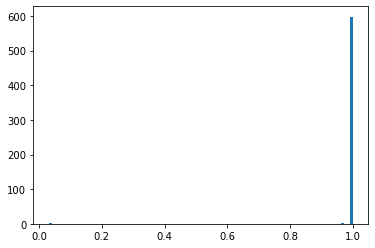

In [29]:
_ = plt.hist(res, bins=100)

In [30]:
sum(res > 0.99) / len(res), sum(res > 0.9) / len(res), sum(res < 0.5) / len(res)

(0.9966666666666667, 0.9983333333333333, 0.0016666666666666668)

In [31]:
np.where(res < 0.5)

(array([300], dtype=int64),)

In [33]:
idx = 300
corpus.iloc[idx].q_title, corpus.iloc[idx].a_body

('How could this be done?',
 '<p>Look up Catmull-Rom splines. <a href="http://www.mvps.org/directx/articles/catmull/" rel="nofollow noreferrer">Here\'s an introduction.</a></p>\r\n\r\n<p>Further reading:</p>\r\n\r\n<ul>\r\n<li><a href="https://stackoverflow.com/questions/1085617/catmull-rom-splines-how-do-they-work">Catmull-Rom splines - how do they work?</a></li>\r\n<li><a href="http://actionsnippet.com/?p=1031" rel="nofollow noreferrer">http://actionsnippet.com/?p=1031</a></li>\r\n<li><a href="http://www.cse.unsw.edu.au/~lambert/splines/CatmullRom.html" rel="nofollow noreferrer">http://www.cse.unsw.edu.au/~lambert/splines/CatmullRom.html</a> (<a href="http://www.cse.unsw.edu.au/~lambert/splines/source.html" rel="nofollow noreferrer">source</a>)</li>\r\n</ul>')

# Find Similar entries

In [35]:
corpus.iloc[102].to_dict()

{'q_id': 50009205,
 'q_title': 'Neo4j GraphQL graphql.idl no interface generated',
 'tags': 'neo4jgraphql',
 'accepted_answer_id': 50018616,
 'a_body': '<p>This works for me:</p>\r\n\r\n<p>I changed</p>\r\n\r\n<ul>\r\n<li>DateTime to String</li>\r\n<li>the *_ role to String</li>\r\n<li>AddressSpec to String</li>\r\n<li>Added directions</li>\r\n</ul>\r\n\r\n<p>then</p>\r\n\r\n<pre><code>CALL graphql.idl(\r\n\'type Address {\r\n  id: ID!\r\n  display_name: String\r\n  adress_spec: String!\r\n  adress_from: Originator! @relation(name: "From")\r\n  adress_sender: Originator @relation(name: "Sender")\r\n  adress_reply_to: Originator @relation(name: "ReplyTo")\r\n  destination_to: [Destination] @relation(name: "To")\r\n  destination_cc: [Destination] @relation(name: "Cc")\r\n  destination_bcc: [Destination] @relation(name: "Bcc")\r\n}\r\n\r\ntype Originator {\r\n  id: ID!\r\n  origin_date: String!\r\n  originator_role: String!\r\n  message: [Message!] @relation(name: "Originator", direction:

In [36]:
idx = 102
sentence_pairs = convert_sentence_pair(
    [corpus.iloc[idx]["q_title"]] * corpus.shape[0], 
    corpus.a_body.tolist(), max_seq_length=200, tokenizer=tokenizer)

11/06/2019 18:36:47 - INFO - bert -   *** Example ***
11/06/2019 18:36:47 - INFO - bert -   tokens: [CLS] neo ##4 ##j graph ##q ##l graph ##q ##l . id ##l no interface generated [SEP] < p > here it is : < / p > < p > u have to add vendor prefix ##es < / p > < pre > < code > . twitter - bird { height : 38 ##p ##x ; width : 37 . 5 ##p ##x ; background - image : ur ##l ( " http : / / dl . drop ##box ##user ##con ##ten ##t . com / u / 105 ##0 ##46 ##43 ##6 / t ##w . p ##ng " ) ; } . twitter - bird : hove ##r { - web ##kit - animation : fly . 4 ##s steps ( 3 ) infinite ; - mo ##z - animation : fly . 4 ##s steps ( 3 ) infinite ; - ms - animation : fly . 4 ##s steps ( 3 ) infinite ; - o - animation : fly . 4 ##s steps ( 3 ) infinite ; animation : fly . 4 ##s steps ( 3 ) infinite ; } @ - web ##kit - key ##frame ##s fly [SEP]
11/06/2019 18:36:47 - INFO - bert -   input_ids: 101 9253 2549 3501 10629 4160 2140 10629 4160 2140 1012 8909 2140 2053 8278 7013 102 1026 1052 1028 2182 2009 2003 1024 10

11/06/2019 18:36:47 - INFO - bert -   *** Example ***
11/06/2019 18:36:47 - INFO - bert -   tokens: [CLS] neo ##4 ##j graph ##q ##l graph ##q ##l . id ##l no interface generated [SEP] < pre > < code > using unity ##eng ##ine ; using system . collections ; public class random ##ise ##back ##ground : mono ##be ##ha ##vio ##ur { public sp ##rite ##ren ##der ##er backgrounds ##pr ##iter ##end ##ere ##r ; public sp ##rite [ ] backgrounds ##pr ##ites ; / / use this for initial ##ization void start ( ) { int days ##tar ##t = 7 ; int days ##top = 22 ; if ( date ##time . now . hour & gt ; days ##tar ##t & amp ; & amp ; date ##time . now . hour & lt ; days ##top ) { / / display background by day } else { / / display background by night } } < / code > < / pre > < p > is this what you ' re looking for ? you could adjust it to use the pm / am method . . < / p > [SEP]
11/06/2019 18:36:48 - INFO - bert -   input_ids: 101 9253 2549 3501 10629 4160 2140 10629 4160 2140 1012 8909 2140 2053 8278 7013 102

In [37]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

11/06/2019 18:36:58 - INFO - bert -   ***** Running evaluation *****
11/06/2019 18:36:58 - INFO - bert -     Num examples = 600
11/06/2019 18:36:58 - INFO - bert -     Batch size = 128


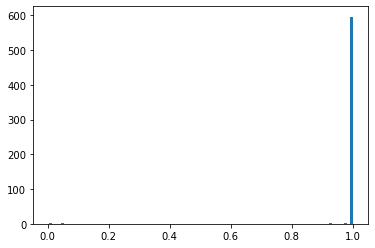

In [38]:
_ = plt.hist(res, bins=100)

In [39]:
best_matches = np.argsort(res)[::-1][:10]
best_matches

array([560, 528, 102, 364, 581, 312,  78, 558,   5, 574], dtype=int64)

In [41]:
from pprint import pprint
for _, row in corpus.iloc[best_matches].iterrows():
    pprint(row.to_dict())

{'a_body': '<p>You can use <a href="https://www.npmjs.com/package/graphql-tag" '
           'rel="noreferrer">graphql-tag</a> :</p>\r\n'
           '\r\n'
           "<pre><code>const gql = require('graphql-tag');\r\n"
           '\r\n'
           'const query = `\r\n'
           '  {\r\n'
           '    qQueryEndpoint {\r\n'
           '      id\r\n'
           '    }\r\n'
           '  }\r\n'
           '`;\r\n'
           '\r\n'
           'const obj = gql`\r\n'
           '  ${query}\r\n'
           '`;\r\n'
           '\r\n'
           "console.log('operation', obj.definitions[0].operation);\r\n"
           "console.log('name', "
           'obj.definitions[0].selectionSet.selections[0].name.value);\r\n'
           '</code></pre>\r\n'
           '\r\n'
           '<p>Prints out :</p>\r\n'
           '\r\n'
           '<pre><code>operation query\r\n'
           'name qQueryEndpoint\r\n'
           '</code></pre>\r\n'
           '\r\n'
           '<p>And with your mutation :</p>\r\

 'q_title': 'What is the correct syntax for Powershell AzureADPreview cmdlet '
            'Set-AzureADApplication "PreAuthorizedApplications" parameter?',
 'tags': 'powershellmicrosoft-graphazure-powershellazure-ad-graph-api'}
{'a_body': '<p>By default,Facebook Graphi API returns only the first 1000 '
           "results,Doesn't matter what your Limit Parameter is set to.</p>\r\n"
           '\r\n'
           '<p>To overcome this problem,There is a paging key provided in the '
           'JSON parsed array,Something like this,</p>\r\n'
           '\r\n'
           '<p><code>"paging": {\r\n'
           '      "cursors": {\r\n'
           '        "after": "MzE0NzA0Njc0ODE0", \r\n'
           '        "before": "Nzc5NTQ3MDU1NDAyNjc4"\r\n'
           '      }, \r\n'
           '      "next": '
           '"https://graph.facebook.com/v2.0/734056698/likes?limit=25&amp;after=MzE0NzA0Njc0ODE0"\r\n'
           '    }\r\n'
           '</code></p>\r\n'
           '\r\n'
           '<p>Here,You 